In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, auc
)

plt.rcParams["figure.figsize"] = (8, 6)


In [4]:
#  Data Loading & Basic Preparation
df = pd.read_csv("diabetes_diagnosis_clean.csv")
print(f"Dataset Shape: {df.shape}")

df = df.fillna(df.mode().iloc[0])

y = df["Diabetes"].astype(int)
X = df.drop(columns=["Diabetes", "Number"])


categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

Dataset Shape: (243618, 23)
Training set: (194894, 21), Test set: (48724, 21)


In [ ]:
# preprocessing pipeline
if len(numerical_cols) > 0 and len(categorical_cols) > 0:
    preprocess = ColumnTransformer([
        ("num", StandardScaler(), numerical_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ])
elif len(numerical_cols) > 0:
    preprocess = ColumnTransformer([
        ("num", StandardScaler(), numerical_cols)
    ])
else:
    preprocess = ColumnTransformer([
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ])


# Feature Selection (Numeric Features)
if len(numerical_cols) > 0:
    df_num = df.select_dtypes(include=[np.number])
    
    sel = VarianceThreshold(threshold=0.01)
    sel.fit(df_num)
    selected_cols = df_num.columns[sel.get_support()]
    
    removed_cols = [c for c in df_num.columns if c not in selected_cols]
    
    X = df[selected_cols.tolist() + [c for c in df.columns if c not in df_num.columns and c != "Diabetes"]]
else:
    X = df[[c for c in df.columns if c not in df_num.columns and c != "Diabetes"]]

print(f"Final feature set: {X.shape[1]} features")

Final feature set: 23 features


In [9]:
# Model Selection and Parameter Tuning
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  

models_and_params = {
    "LogisticRegression": (
        LogisticRegression(max_iter=1000, class_weight="balanced", n_jobs=-1),
        {"model__C": [0.5, 1.0, 2.0]}  
    ),
    "DecisionTree": (
        DecisionTreeClassifier(class_weight="balanced", random_state=42),
        {"model__max_depth": [6, 8, 10]}  
    ),
    "RandomForest": (
        RandomForestClassifier(
            n_estimators=100,  
            class_weight="balanced", n_jobs=-1, random_state=42
        ),
        {"model__max_depth": [6, 8, 10], "model__max_features": ["sqrt"]}  # 
    ),
}

results, best_estimators = [], {}

In [14]:
# Training and Evaluation
for name, (estimator, param_grid) in models_and_params.items():
    print(f"{name}")
    start = time.time()

    pipe = Pipeline([("preprocessor", preprocess), ("model", estimator)])

    gs = GridSearchCV(
        pipe, param_grid, scoring="roc_auc", cv=cv, n_jobs=-1, verbose=0
    )
    gs.fit(X_train, y_train)

    elapsed = time.time() - start
    best_estimators[name] = gs.best_estimator_

    y_prob = gs.best_estimator_.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)

    results.append({
        "model": name,
        "best_params": gs.best_params_,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred, zero_division=0),
        "f1": f1_score(y_test, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_test, y_prob),
        "train_time_sec": round(elapsed, 2)
    })

    print(f"Best parameters: {gs.best_params_}")
    print(f"Test AUC: {roc_auc_score(y_test, y_prob):.4f}")
    print(f"Training time: {elapsed:.2f} s\n")

LogisticRegression
Best parameters: {'model__C': 0.5}
Test AUC: 0.7853
Training time: 5.41 s

DecisionTree
Best parameters: {'model__max_depth': 8}
Test AUC: 0.7745
Training time: 7.70 s

RandomForest
Best parameters: {'model__max_depth': 10, 'model__max_features': 'sqrt'}
Test AUC: 0.7872
Training time: 84.74 s



In [15]:
# Results
res_df = pd.DataFrame(results).sort_values("roc_auc", ascending=False)
print("Model Comparison")
print(res_df[["model","accuracy","precision","recall","f1","roc_auc","train_time_sec"]])

best_model_name = res_df.iloc[0]['model']
best_model = best_estimators[best_model_name]
print(f"\n Best Model: {best_model_name}")
print(f"Best Parameters: {res_df.iloc[0]['best_params']}")
print(f"test AUC: {res_df.iloc[0]['roc_auc']:.4f}")

Model Comparison
                 model  accuracy  precision    recall        f1   roc_auc  \
2         RandomForest  0.695448   0.307556  0.741458  0.434769  0.787224   
7         RandomForest  0.695448   0.307556  0.741458  0.434769  0.787224   
10        RandomForest  0.695448   0.307556  0.741458  0.434769  0.787224   
8   LogisticRegression  0.707208   0.314004  0.720411  0.437372  0.785255   
0   LogisticRegression  0.707208   0.314004  0.720411  0.437372  0.785255   
3   LogisticRegression  0.707208   0.314004  0.720411  0.437372  0.785255   
5   LogisticRegression  0.707208   0.314004  0.720411  0.437372  0.785255   
1         DecisionTree  0.657335   0.285605  0.778745  0.417933  0.774518   
4         DecisionTree  0.657335   0.285605  0.778745  0.417933  0.774518   
6         DecisionTree  0.657335   0.285605  0.778745  0.417933  0.774518   
9         DecisionTree  0.657335   0.285605  0.778745  0.417933  0.774518   

    train_time_sec  
2            97.15  
7           100.

In [16]:
# Analysis
for name, est in best_estimators.items():
    print(f"\n{name}")
    y_prob = est.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)
    print("confusion matrix:")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, digits=3, zero_division=0))


LogisticRegression
confusion matrix:
[[28913 12114]
 [ 2152  5545]]
              precision    recall  f1-score   support

           0      0.931     0.705     0.802     41027
           1      0.314     0.720     0.437      7697

    accuracy                          0.707     48724
   macro avg      0.622     0.713     0.620     48724
weighted avg      0.833     0.707     0.744     48724


DecisionTree
confusion matrix:
[[26034 14993]
 [ 1703  5994]]
              precision    recall  f1-score   support

           0      0.939     0.635     0.757     41027
           1      0.286     0.779     0.418      7697

    accuracy                          0.657     48724
   macro avg      0.612     0.707     0.588     48724
weighted avg      0.835     0.657     0.704     48724


RandomForest
confusion matrix:
[[28178 12849]
 [ 1990  5707]]
              precision    recall  f1-score   support

           0      0.934     0.687     0.792     41027
           1      0.308     0.741     0.43

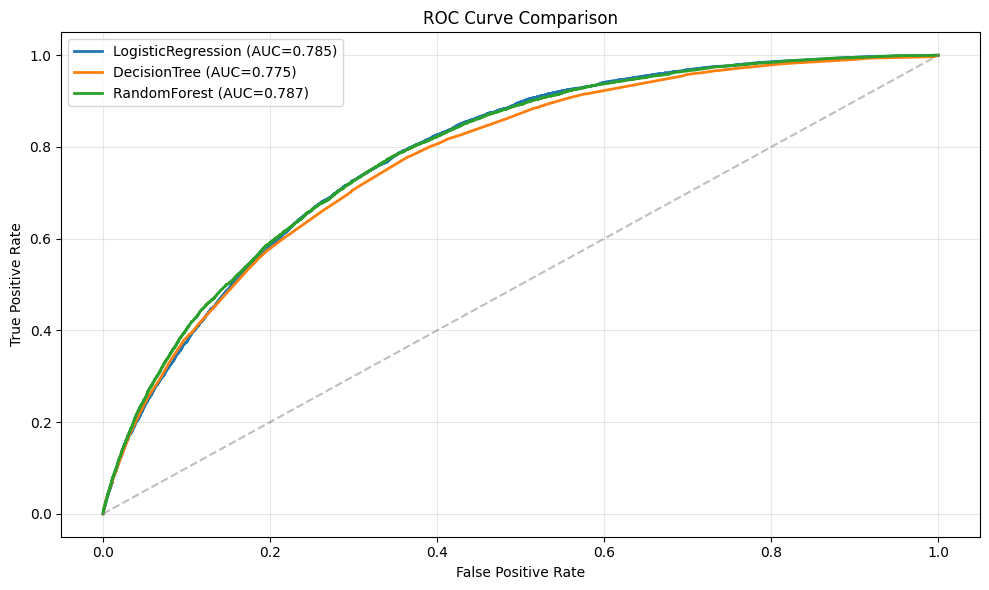

In [ ]:
# ROC Curve
plt.figure(figsize=(10, 6))
for name, est in best_estimators.items():
    y_prob = est.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc(fpr,tpr):.3f})", linewidth=2)

plt.plot([0,1], [0,1], "--", color="grey", alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

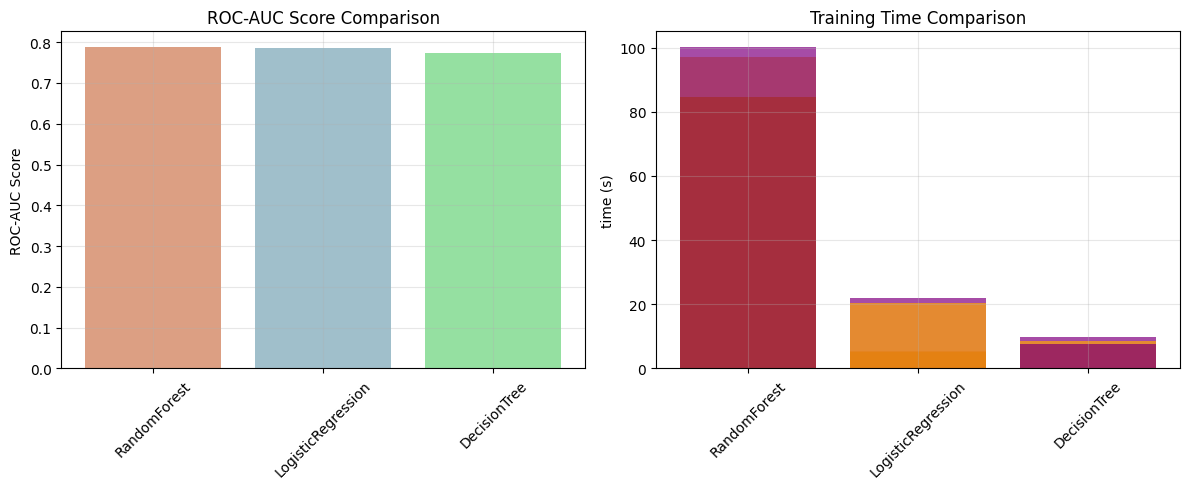

In [18]:
# Performance Metrics Comparison
plt.figure(figsize=(12, 5))

# ROC-AUC
plt.subplot(1, 2, 1)
auc_scores = res_df['roc_auc'].values
model_names = res_df['model'].values
plt.bar(model_names, auc_scores, alpha=0.7, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('ROC-AUC Score Comparison')
plt.ylabel('ROC-AUC Score')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# trainning time
plt.subplot(1, 2, 2)
train_times = res_df['train_time_sec'].values
plt.bar(model_names, train_times, alpha=0.7, color=['orange', 'purple', 'brown'])
plt.title('Training Time Comparison')
plt.ylabel('time (s)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()